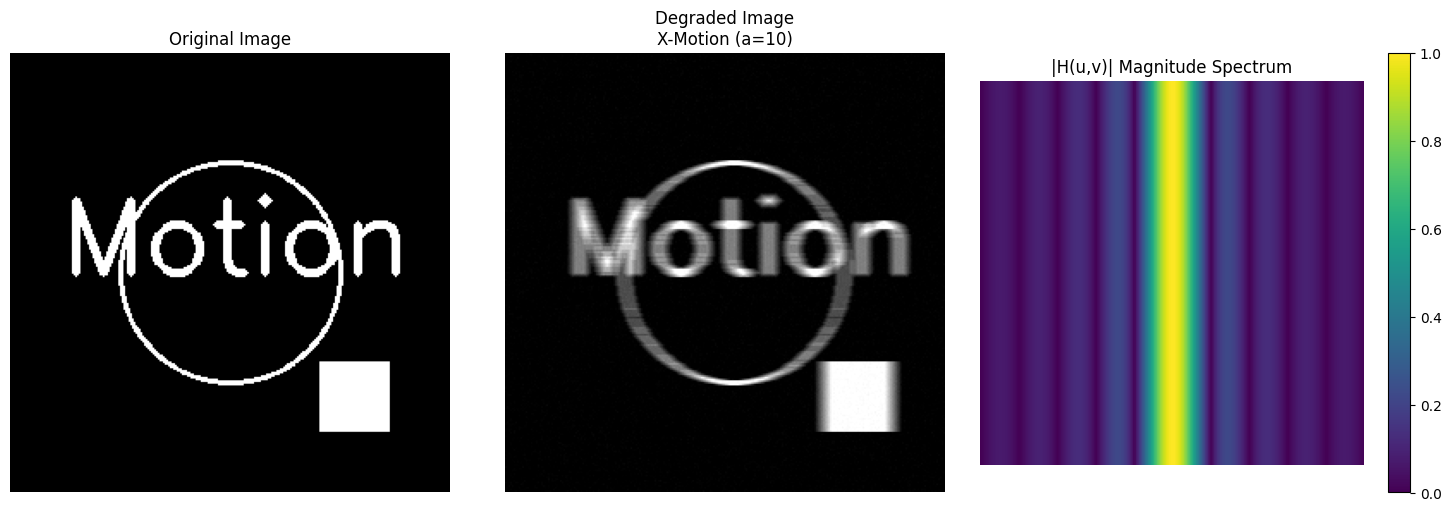

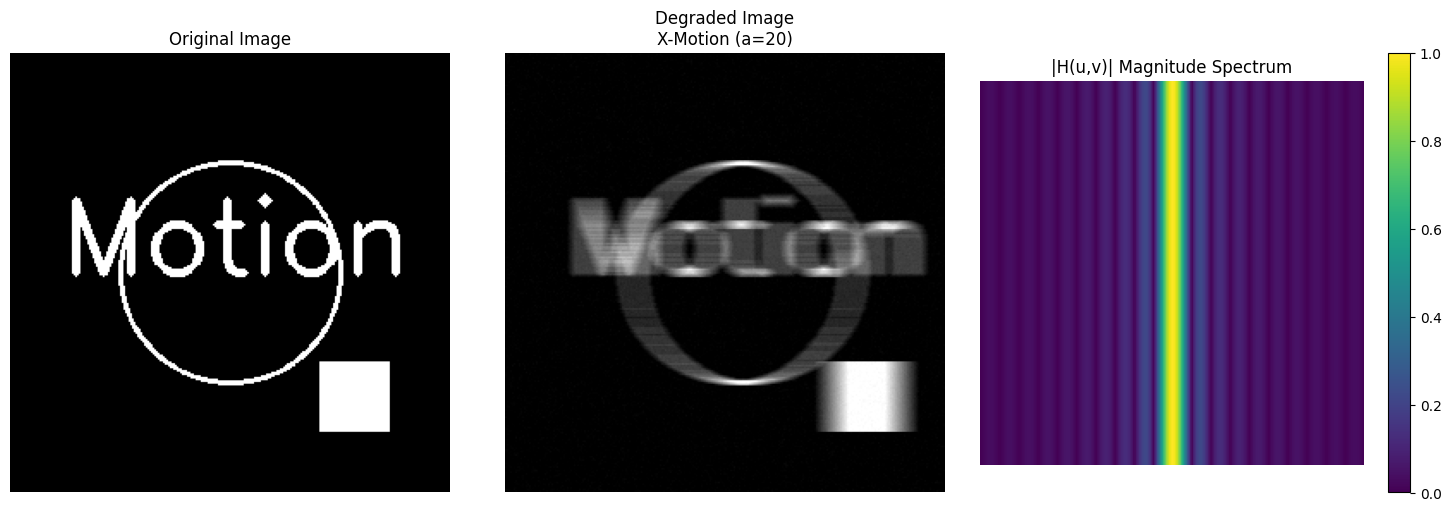

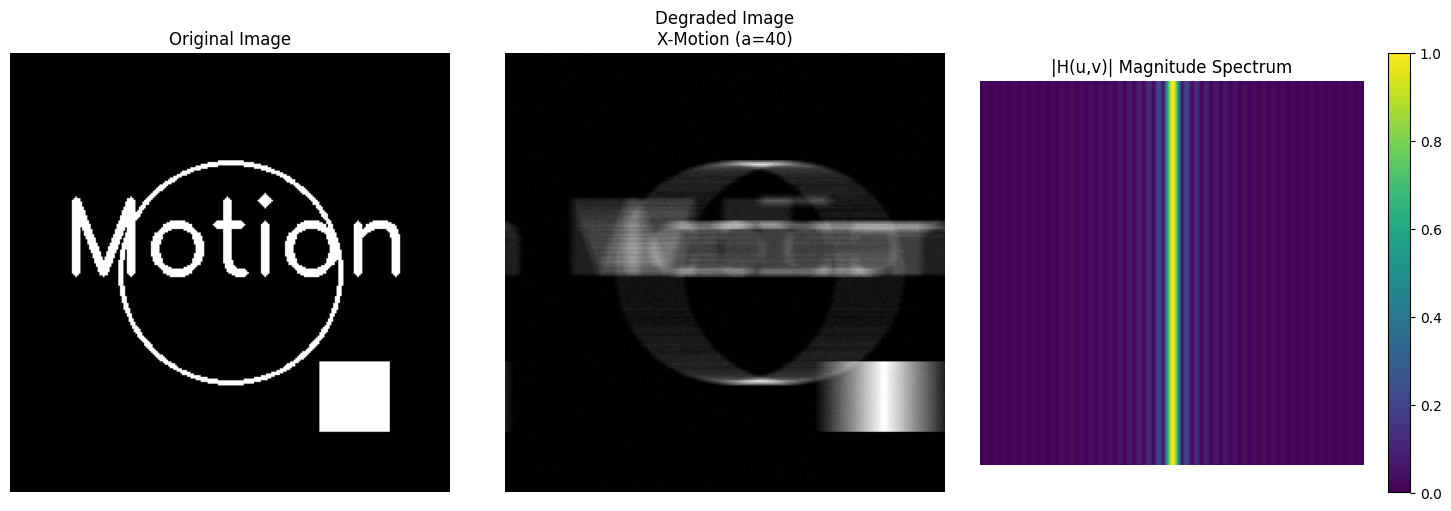

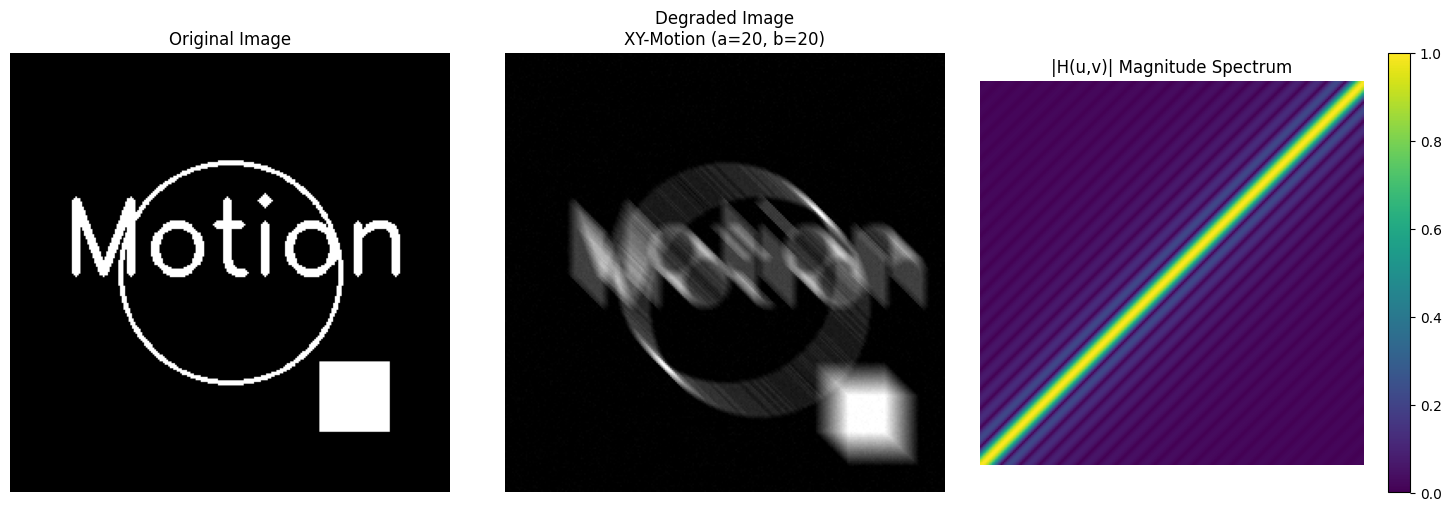

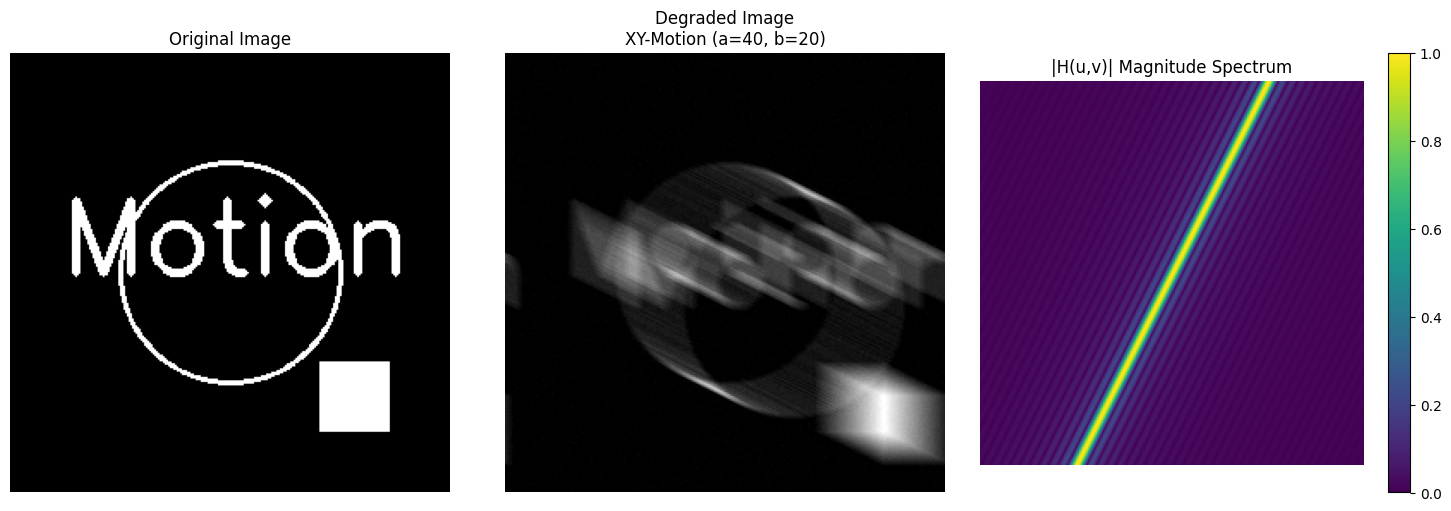

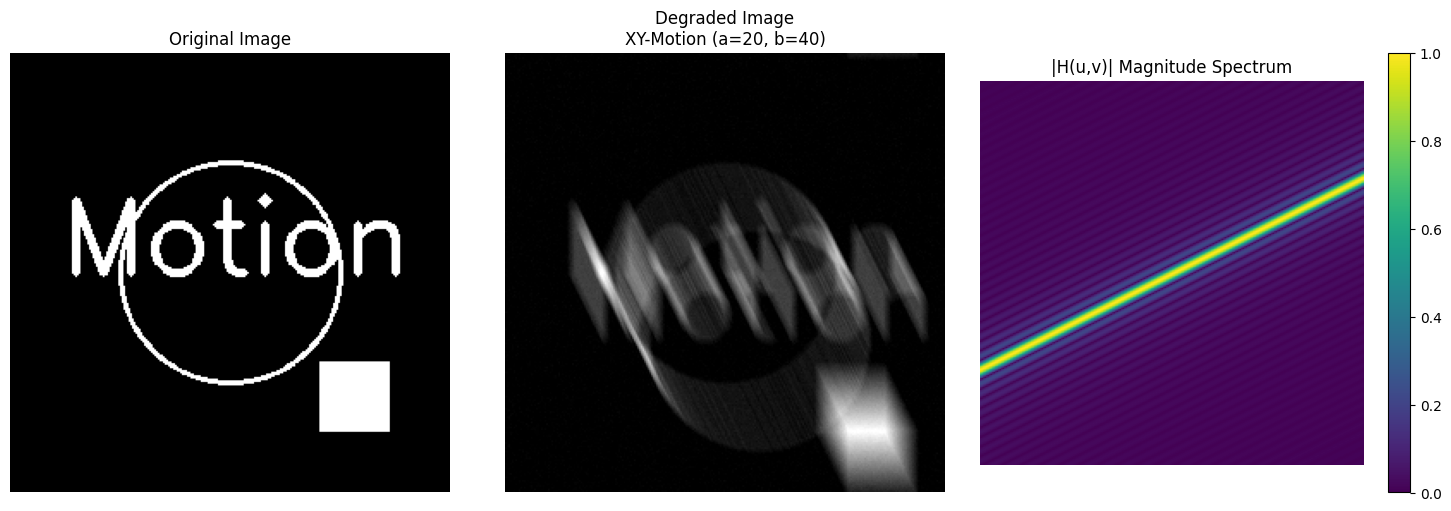

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_frequency_grid(M, N):
    """Create frequency grid for MxN image."""
    u = np.fft.fftfreq(M)
    v = np.fft.fftfreq(N)
    u, v = np.meshgrid(u, v)
    return u, v

def motion_degradation_x(u, v, T=1, a=20):
    """
    Motion blur degradation function for x-direction.
    H(u,v) = (T/(π*u*a))*sin(π*u*a)*exp(-jπ*u*a)
    """
    # Avoid division by zero
    eps = 1e-10
    ua = u * a + eps
    H = T * np.sinc(ua) * np.exp(-1j * np.pi * ua)
    return H

def motion_degradation_xy(u, v, T=1, a=20, b=20):
    """
    Motion blur degradation function for both x and y directions.
    H(u,v) = (T/π(ua+vb))*sin(π(ua+vb))*exp(-jπ(ua+vb))
    """
    # Avoid division by zero
    eps = 1e-10
    uavb = (u * a + v * b) + eps
    H = T * np.sinc(uavb) * np.exp(-1j * np.pi * uavb)
    return H

def degrade_image(image, degradation_func, **params):
    """Apply motion degradation to image."""
    # Convert image to float
    img_float = image.astype(float) / 255.0

    # Get image dimensions and frequency grid
    M, N = image.shape
    u, v = create_frequency_grid(M, N)

    # Calculate degradation function
    H = degradation_func(u, v, **params)

    # Apply degradation in frequency domain
    F = np.fft.fft2(img_float)
    G = H * F

    # Transform back to spatial domain
    degraded = np.real(np.fft.ifft2(G))

    # Add small amount of noise
    noise = np.random.normal(0, 0.01, degraded.shape)
    degraded = degraded + noise

    # Clip and convert back to uint8
    return np.clip(degraded * 255, 0, 255).astype(np.uint8), H

def load_test_image(size=(256, 256)):
    """Create a test image with some patterns."""
    img = np.zeros(size, dtype=np.uint8)

    # Add some patterns
    cv2.putText(img, 'Motion', (30, 128), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 3)
    cv2.circle(img, (128, 128), 64, 255, 2)
    cv2.rectangle(img, (180, 180), (220, 220), 255, -1)

    return img

def visualize_results(original, degraded, H, title):
    """Visualize results with magnitude spectrum of degradation function."""
    plt.figure(figsize=(15, 5))

    # Original image
    plt.subplot(131)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    # Degraded image
    plt.subplot(132)
    plt.imshow(degraded, cmap='gray')
    plt.title(f'Degraded Image\n{title}')
    plt.axis('off')

    # Degradation function magnitude spectrum
    plt.subplot(133)
    H_mag = np.abs(np.fft.fftshift(H))
    plt.imshow(H_mag, cmap='viridis')
    plt.title('|H(u,v)| Magnitude Spectrum')
    plt.colorbar()
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    # Load test image
    image = load_test_image()

    # Test cases

    # 1. X-direction motion with different speeds
    for a in [10, 20, 40]:  # Different motion amounts
        degraded, H = degrade_image(image, motion_degradation_x, T=1, a=a)
        visualize_results(image, degraded, H, f'X-Motion (a={a})')

    # 2. XY-direction motion with different speeds
    for a, b in [(20,20), (40,20), (20,40)]:  # Different motion amounts
        degraded, H = degrade_image(image, motion_degradation_xy, T=1, a=a, b=b)
        visualize_results(image, degraded, H, f'XY-Motion (a={a}, b={b})')

if __name__ == "__main__":
    main()